# TweetLens: Tech Layoff

Since late 2022, the tech industry has experienced a significant wave of layoffs affecting companies of all sizes across the globe. Tech giants including Meta, Amazon, Microsoft, Google, and numerous startups have announced substantial workforce reductions, with hundreds of thousands of tech workers losing their jobs. These layoffs have occurred against a backdrop of economic uncertainty, post-pandemic market corrections, and strategic pivots within the industry.

The widespread nature of these layoffs has sparked intense discussion on social media platforms, particularly Twitter, where affected employees, industry observers, executives, and the general public share their experiences, opinions, and emotional responses. These conversations provide valuable insights into how people perceive and process these industry shifts.

In this notebook, we'll explore:
1. How people feel about tech layoff in general
2. What specific emotions dominate the conversation
3. How sentiment has evolved over time as layoffs have continued

## 1. Fetching tweets from Twitter API

To begin, I'll fetch the tweets from Twitter API and save it to a csv file

In [ ]:
import tweepy
import pandas as pd

BEARER_TOKEN = ""

client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)

def fetch_tweets(client, query, max_results=100): 
    tweets = [] 
    response = client.search_recent_tweets( 
        query=query, 
        tweet_fields=["created_at", "public_metrics", "author_id", "text"], 
        max_results=max_results 
    ) 
    if response.data: 
        for tweet in response.data: 
            tweets.append({ 
                "created_at": tweet.created_at, 
                "text": tweet.text, "retweets": tweet.public_metrics['retweet_count'], 
                "likes": tweet.public_metrics['like_count'] 
            }) 
    return pd.DataFrame(tweets)

query = "Tech Layoff"
tweets_df = fetch_tweets(client, query, max_results=80)
print(tweets_df)

if tweets_df.empty:
    print("No tweets found.")

In [ ]:
file_path = 'tweets.csv'

try:
    existing_df = pd.read_csv(file_path, index_col=0)
    
    if existing_df.empty:
        last_index = -1  
    else:
        last_index = existing_df.shape[0] - 1  
except (FileNotFoundError, pd.errors.EmptyDataError):
    last_index = -1  

print(f"Last index in the file: {last_index}")

tweets_df.index = range(last_index + 1, last_index + 1 + len(tweets_df))

tweets_df.to_csv(file_path, mode='a', header=False)

print(f"New data appended starting from index {last_index + 1}.")


Here is our tweets that we just fetched!

In [2]:
import pandas as pd
data = pd.read_csv("./Week_3_Assignment _ AnhTran/tweets.csv")
data.head()

,Unnamed: 0,created_at,text,retweets,likes
0,0,2025-03-24 14:24:22+00:00,@MarioNawfal I used to work for the company Ge...,0,0
1,1,2025-03-24 13:31:57+00:00,"So the best, the ""greatest deal maker,"" and th...",0,0
2,2,2025-03-24 13:11:38+00:00,@rolodexter_ai's ingesting images and transcri...,0,0
3,3,2025-03-24 09:56:23+00:00,Boeing has a presence in India for about 75 ye...,0,0
4,4,2025-03-24 03:06:30+00:00,@dintaifungenak Dikit dikit 5.0 \nIndustrialis...,0,0


## 2. Generating Tweets Using Transformers

Because our Twitter API access is capped at just 100 tweet fetches per month, we instead employ Transformer-based language models to synthesize the additional tweets we need.

### 2.1. Generate 10,000 tweets using Transformer
I generate 1,000 tweets 10 times because I got an error when I tried to generate 10,000 tweets

In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model = "gpt2")

def generate_tweets(prompt, num_tweets = 5):
    return generator(prompt, num_return_sequences = num_tweets)

prompt = "Generate a tweet about tech layoff"

synthetic_tweets = generate_tweets(prompt, 1000)

### 2.2.  Write the generated tweets to a CSV file

In [ ]:
import csv
# Write tweets to a CSV file
csv_filename = "generated_tweets.csv"
with open(csv_filename, mode="a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for tweet in synthetic_tweets:
        writer.writerow([tweet["generated_text"]])

### 2.3. Combine the generated tweets and the tweets from Twitter API
Let's combine two datasets in to one. I also remove the prompt "Generate a tweet about tech layoff" in the generated tweets

In [ ]:
import pandas as pd
import re
# Combine 2 df, one is retrived from Twitter API, one is created with Transformer
df1 = pd.read_csv('./Week_4_Assignment _ AnhTran/generated_tweets.csv')
df1['Tweet'] = df1['Tweet'].apply(lambda x: re.sub(r'Generate a tweet about tech layoff[^\w\s]*', '', str(x)))  
df2 = pd.read_csv('./Week_4_Assignment _ AnhTran/tweets.csv')
df2_tweets = df2[['text']].rename(columns={'text': 'Tweet'})
df_combined = pd.concat([df1, df2_tweets], ignore_index=True)
df_combined.to_csv('combined_tweets.csv', index=False)

### 2.4. Perform text preprocessing

Before analyzing tweets, I'll do text preprocessing. Here are the techinques that I use:
- Text normalization (lowercasing)
- URL removal
- HTML tag removal
- Punctuation removal
- Whitespace management
- Alphanumeric word removal
- Tokenization
- Stopword removal
- Lemmatization


In [ ]:
import re
import string
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the tokenizer and lemmatizer
wpt = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

# Create a stopwords set
stop_words = set(stopwords.words('english'))

def normalized_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = text.lower()
        text = re.sub(r'\[.*?\]', ' ', text)
        text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
        text = re.sub(r'<.*?>+', ' ', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'\w*\d\w*', ' ', text)
        tokens = wpt.tokenize(text)

        # Remove stopwords
        filtered_tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize tokens without stemming
        lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

        cleaned_text = ' '.join(lemma_tokens)
        return cleaned_text
    return ''  # If it's not a string, return an empty string

data = pd.read_csv("combined_tweets.csv")
data['Tweet'] = data['Tweet'].apply(normalized_text)

# Save to new csv file
data.to_csv("cleaned_tweets.csv", index=False)

Let's see our dataset now!

In [3]:
cleaned_tweets = pd.read_csv("./Week_4_Assignment _ AnhTran/cleaned_tweets.csv")
cleaned_tweets.head()

,Tweet
0,— scott gorman scottgorman march surprise one
1,full facebook post tech layoff want add word s...
2,tech official asked speak reporter via video s...
3,best employee get bad press company make look ...
4,clicking


## 4. Exploratory Data Analysis and Conclusion

### 4.1. Word Cloud

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate word cloud based on date range
def generate_word_cloud(df):

    # Combine all cleaned text from the 'cleaned' column into a single string
    cleaned_text = " ".join(df['Tweet'].dropna().tolist())  # Use 'cleaned' column for word cloud

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=None,  # Stopwords already removed in cleaning step
                          collocations=True).generate(cleaned_text)

    # Display the generated word cloud
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Tech Layoff", fontsize=20)
    plt.show()

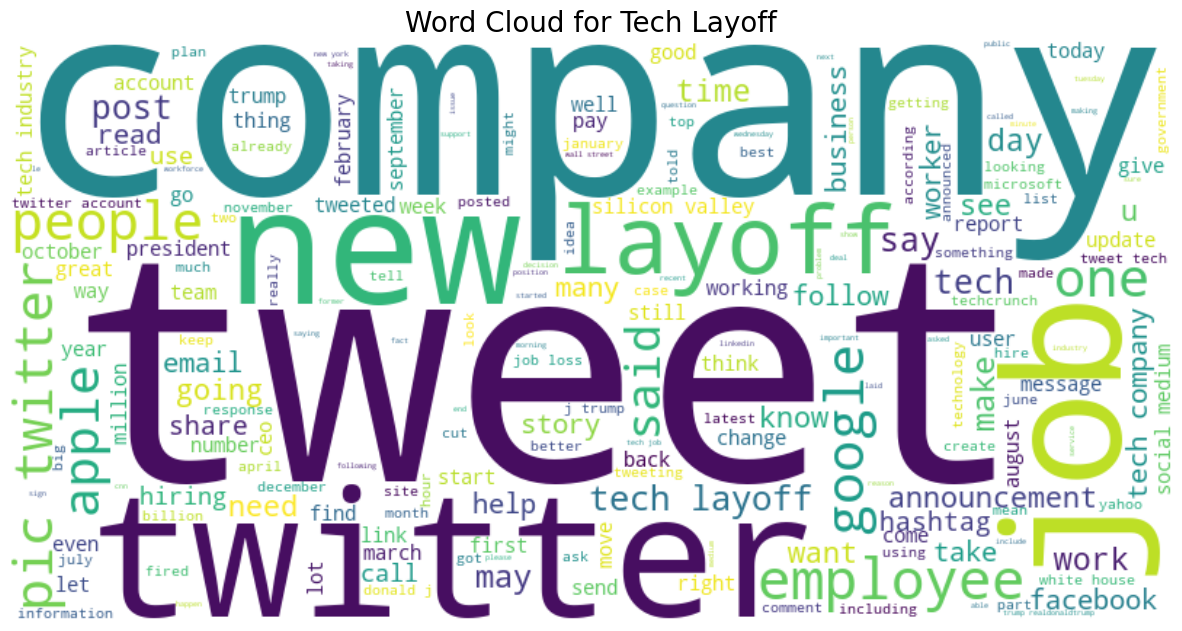

In [5]:
generate_word_cloud(cleaned_tweets)

**Observations**
- Useful words: Words like layoff, employee, company, google, fired, announcement, and tech are informative and domain-relevant.
- Noisy or redundant words:
    - Platform-specific terms: tweet, twitter, pic, email, post, retweet, account, user, follow – these may dominate but don’t add much semantic value regarding layoffs.
    - Generic words: said, know, new, one, day, time, need, got, make, going, look – these are common across many topics and may dilute the focus.
    - Months: march, april, july, etc. – consider filtering these unless you're doing temporal analysis.
    - Pronouns and filler words: If u, j, or partial names like donald j appear, these are usually side-effects of poor tokenization or not cleaning mentions/URLs/names well.

### 4.2. Sentiment Analysis

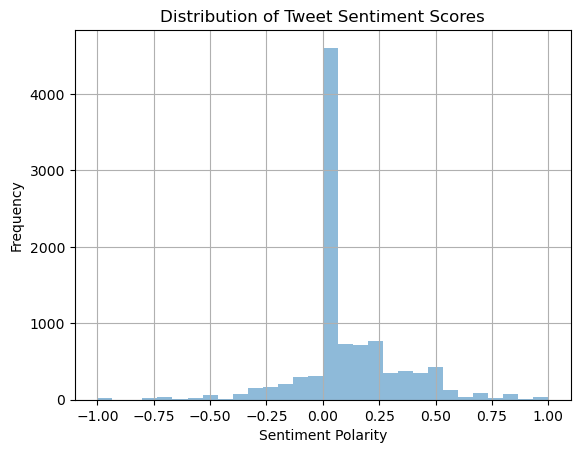

In [6]:
%matplotlib inline
from textblob import TextBlob
import matplotlib.pyplot as plt

df_sentiment = cleaned_tweets.copy()

# Apply sentiment analysis only to non-null, string-cast tweets
df_sentiment['Sentiment'] = df_sentiment['Tweet'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else 0.0
)

# Plot histogram of sentiment polarity scores
df_sentiment['Sentiment'].hist(bins=30, alpha=0.5)
plt.title("Distribution of Tweet Sentiment Scores")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Observations**

- Massive spike at 0: 
    - This suggests that a very large number of tweets have a sentiment polarity of exactly 0.0, which for TextBlob means neutral sentiment.
    - Possible reasons: 
        - Tweets that are short, factual, or lack emotional content.
        - Tweets that were empty or contained only links/emojis/usernames (TextBlob can’t extract sentiment from these).
        - Tweets that were "NaN" or low-quality and were assigned default 0.0 in the code fix.
- Right-skewed distribution:
    - There are more tweets with positive sentiment (right side of the histogram) than negative.
    - Positive tweets (e.g., > 0.1) seem to dominate the distribution, likely praising companies, sharing hopeful stories, or announcing news.
- Low frequency on the negative side:
    - Negative tweets (e.g., < -0.1) exist but are relatively fewer.
    - This might be surprising given the topic (“tech layoffs”), which you'd expect to evoke negative emotions.
    - Possible reason: people might post informative, neutral reports rather than personal emotional reactions.

### 4.3. Emotion Analysis

In [7]:
from nrclex import NRCLex
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tranminhanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

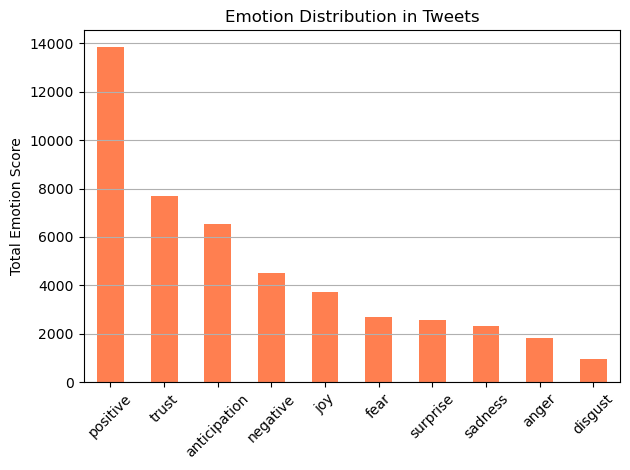

In [8]:
# Create a copy to work with
df_emotion = cleaned_tweets.copy()

# Ensure text is a string
df_emotion['Tweet'] = df_emotion['Tweet'].astype(str)

# Extract emotions
def get_emotions(text):
    emo = NRCLex(text)
    return emo.top_emotions  # list of tuples [('emotion', score), ...]

# You can also use .raw_emotion_scores to get full dict

df_emotion['Emotions'] = df_emotion['Tweet'].apply(lambda x: NRCLex(x).raw_emotion_scores)

# Convert to a DataFrame of emotion counts
emotion_counts = pd.DataFrame(df_emotion['Emotions'].tolist()).fillna(0).sum().sort_values(ascending=False)

# Plotting emotion distribution
emotion_counts.plot(kind='bar', color='coral')
plt.title("Emotion Distribution in Tweets")
plt.ylabel("Total Emotion Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The emotion analysis shows that positive, trust, and anticipation are the most common emotions in tweets about tech layoffs. This suggests that despite the negative topic, people often frame their messages with optimism or future focus. Negative emotions like anger, sadness, and fear appear less frequently, indicating that many tweets are either neutral or solution-oriented rather than emotionally charged.

### 4.4. Conclusion
- Positive emotions, trust, and anticipation emerge as the most common emotions expressed in tweets about tech layoffs. Despite the challenging nature of job losses, many social media users frame their messages with optimism and future-focused perspectives.
- Common themes in positive-sentiment posts included networking support, job opportunity sharing, and industry resilience narratives. This community response highlights the tech sector's strong professional networks and mutual support systems.